In [26]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, LSTM
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.losses import MeanSquaredError
from keras.optimizers import Adam
from keras import regularizers, metrics, backend
from sklearn.preprocessing import MinMaxScaler
from lib import lstm_tools
import os

## **ARIMA input**

In [3]:
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.path.pardir))
files_dir = os.path.join(parent_dir, 'data/VARMA_ARIMA/after_ARIMA/')
data = []
d = 0

for file in os.listdir(files_dir):
    file_path = os.path.join(files_dir, file)
    df = pd.read_csv(file_path, index_col='date', parse_dates=True)
    if not d:
        dates = df.index
        d = 1
    if np.isnan(df).any().any() or np.isnan(df).any().any() :
        print(file)
        continue
    data.append(df.reset_index(drop=True))

## **預處理：MinMax Scaler**

In [4]:
# scaler = MinMaxScaler()

## **預處理：切割資料集**

In [5]:
X, y, train_X, train_y, val_X, val_y, test_X, test_y = [],[],[],[],[],[],[],[]
past_n = 5
future_n = 1

for pair_corr in data:
    # scaler.fit(pair_corr)
    # pair_corr = scaler.transform(pair_corr)
    for i in range(past_n, len(pair_corr) - future_n + 1):
        X.append(pair_corr[i - past_n:i])
        y.append(pair_corr[i + future_n - 1:i + future_n]['close'])

In [6]:
X = np.array([X[i].values.tolist() for i in range(len(X))])
y = np.array([a.values.tolist() for a in y])

In [7]:
train_X, train_y = X[:int(len(X) * 0.7)], y[:int(len(X) * 0.7)]
val_X, val_y = X[int(len(X) * 0.7):int(len(X) * (0.7 + 0.15))], y[int(len(X) * 0.7):int(len(X) * (0.7 + 0.15))]
test_X, test_y = X[int(len(X) * (0.7 + 0.15)):], y[int(len(X) * (0.7 + 0.15)):]

In [8]:
input_shape = (train_X.shape[1], train_X.shape[2])

In [9]:
train_y.shape[1]

1

## **模型訓練**

In [10]:
def rmse(y_true, y_pred):
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true)))

In [11]:
def build_lstm_model(x_shape, y_shape, neurons, dropout_rate, is_doubled_layer, is_regularized):
    model = Sequential()
    if is_doubled_layer:
        model.add(LSTM(neurons, input_shape=x_shape, return_sequences=True))
        model.add(Dropout(dropout_rate))
        model.add(LSTM(int(neurons/2), input_shape=x_shape, return_sequences=True))
        model.add(Dropout(dropout_rate))
    else:
        model.add(LSTM(neurons, input_shape=x_shape))
        model.add(Dropout(dropout_rate))
    if is_regularized:
        model.add(Dense(x_shape[1], 'relu',  kernel_regularizer=regularizers.l2(0.01)))
    else:
        model.add(Dense(x_shape[1], 'relu'))
    model.add(Dense(y_shape, 'linear'))
    
    adam = Adam(lr=0.001)
    mse = MeanSquaredError()
    model.compile(optimizer=adam, loss=mse, metrics=[metrics.MSE, metrics.MAE])
    return model

In [12]:
model = build_lstm_model(input_shape, 1, 64, 0.5, 0, 1)
model.summary()

2023-05-11 04:46:57.649812: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                18688     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 19,217
Trainable params: 19,217
Non-trainable params: 0
_________________________________________________________________


2023-05-11 04:46:57.967652: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-11 04:46:57.969395: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-11 04:46:57.970742: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [14]:
checkpoint_dir = os.path.join(parent_dir, 'models/0511.h5')
early_stopping = EarlyStopping(monitor='val_loss', patience=6)
checkpoint_callback = ModelCheckpoint(checkpoint_dir, monitor='val_loss', verbose=1, 
                                      mode='min', save_best_only=True)
lr_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=3, min_lr=0.0005)


In [16]:
history = model.fit(train_X, train_y, epochs=100, batch_size=128, validation_data=(val_X, val_y), callbacks=[early_stopping, checkpoint_callback, lr_reduction])

Epoch 1/100
910/911 [============================>.] - ETA: 0s - loss: 0.1961 - mean_squared_error: 0.1959 - mean_absolute_error: 0.3650
Epoch 1: val_loss improved from 0.19665 to 0.19649, saving model to /home/seco/documents/VARMA-MRRNN/models/0511.h5
911/911 [==============================] - 11s 12ms/step - loss: 0.1961 - mean_squared_error: 0.1959 - mean_absolute_error: 0.3650 - val_loss: 0.1965 - val_mean_squared_error: 0.1963 - val_mean_absolute_error: 0.3671
Epoch 2/100
910/911 [============================>.] - ETA: 0s - loss: 0.1959 - mean_squared_error: 0.1957 - mean_absolute_error: 0.3649
Epoch 2: val_loss did not improve from 0.19649
911/911 [==============================] - 12s 13ms/step - loss: 0.1959 - mean_squared_error: 0.1956 - mean_absolute_error: 0.3649 - val_loss: 0.1966 - val_mean_squared_error: 0.1963 - val_mean_absolute_error: 0.3648
Epoch 3/100
909/911 [============================>.] - ETA: 0s - loss: 0.1957 - mean_squared_error: 0.1954 - mean_absolute_error:

In [22]:
def visialize_loss_plot(history):
    plt.plot(history.history['mean_squared_error'], label='training MSE')
    plt.plot(history.history['val_mean_squared_error'], label='validation MSE')
    plt.legend()
    plt.xlabel('# epochs')
    plt.ylabel('MSE')
    plt.show()

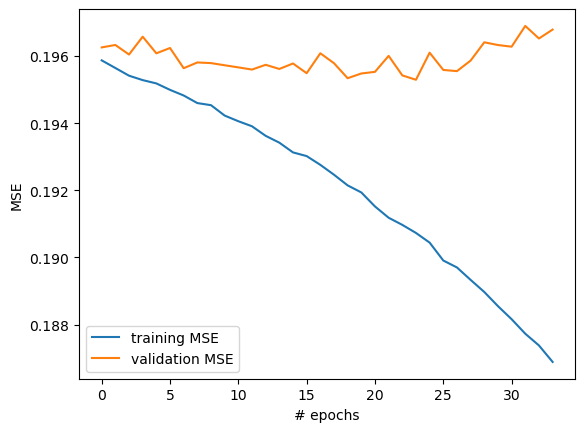

In [23]:
visialize_loss_plot(history)

In [37]:
def evaluate_model(model, train_X, train_y, val_X, val_y, test_X, test_y):
    score_train = model.evaluate(train_X, train_y)
    score_test = model.evaluate(test_X, test_y)
    score_val = model.evaluate(val_X, val_y)
    evaluate_df = pd.DataFrame(np.array([score_train[1], score_val[1], score_test[1], 
                                score_train[2], score_val[2], score_test[2]]).reshape(-1, 6),
                      columns=["train_MSE", "val_MSE", "test_MSE", "train_MAE", "val_MAE", "test_MAE"])
    evaluate_df.to_csv(os.path.join(parent_dir, f'out/LSTM_error/0511.csv'), index=False)
    

In [38]:
best_model = load_model(os.path.join(parent_dir, 'models/0511.h5'))

2023-05-11 05:21:08.364611: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-11 05:21:08.366382: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-11 05:21:08.367711: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [39]:
evaluate_model(best_model, train_X, train_y, val_X, val_y, test_X, test_y)

2023-05-11 05:21:17.331249: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-11 05:21:17.333078: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-11 05:21:17.334463: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

781/781 [==============================] - 4s 4ms/step - loss: 0.1956 - mean_squared_error: 0.1953 - mean_absolute_error: 0.3642


## **預測**